In [1]:
%matplotlib inline
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import types as T

import seaborn as sns

In [2]:
sns.set_style('ticks')
sns.set_context('paper')

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['savefig.dpi'] = 600
matplotlib.rcParams['lines.markersize'] = 3
matplotlib.rcParams['lines.linewidth'] = 1

pd.options.display.width = 200


In [3]:
DATA_DIR = "data"
PLOT_DIR = "plots/JCDL_WOSP"
OUT_DIR = "output"
columns = ["PMID", "Year", "AbsVal", "TFirstP", "VolFirstP",
           "acc_pos_vel_min", "acc_pos_vel_max", "acc_neg_vel_max", "acc_neg_vel_min",
           "Pair_AbsVal", "Pair_TFirstP", "Pair_VolFirstP", "Mesh_counts", "Exploded_Mesh_counts"]



In [4]:
df = sqlContext.read.format("csv").options(header='false', inferschema='true', delimiter='\t').load("out/pmid_novelty_all_scores_mesh_c.txt")
df = df.selectExpr(*("%s as %s" % (df.columns[i], k) for i,k in enumerate(columns)))
print df

for k in ["acc_pos_vel_min", "acc_pos_vel_max", "acc_neg_vel_max", "acc_neg_vel_min",
          "Pair_AbsVal", "Pair_TFirstP", "Pair_VolFirstP"]:
    df = df.withColumn(k, df[k].cast(T.DoubleType()))
print df

DataFrame[PMID: int, Year: int, AbsVal: int, TFirstP: int, VolFirstP: double, acc_pos_vel_min: string, acc_pos_vel_max: string, acc_neg_vel_max: string, acc_neg_vel_min: string, Pair_AbsVal: string, Pair_TFirstP: string, Pair_VolFirstP: string, Mesh_counts: int, Exploded_Mesh_counts: int]
DataFrame[PMID: int, Year: int, AbsVal: int, TFirstP: int, VolFirstP: double, acc_pos_vel_min: double, acc_pos_vel_max: double, acc_neg_vel_max: double, acc_neg_vel_min: double, Pair_AbsVal: double, Pair_TFirstP: double, Pair_VolFirstP: double, Mesh_counts: int, Exploded_Mesh_counts: int]


In [5]:
# Get data for distribution of Scores
score_types = ["TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"]
bins = [range(60), reduce(lambda x, y: x + y, [[0]] + [(10**k*np.arange(1,10)).tolist() for k in range(6)])]
data = []
for i, k in enumerate(score_types):
    print "Processing %s" % k
    j = i % 2
    x, y = df[(df["Year"] >= 1985)].rdd.map(lambda x: x[k]).histogram(bins[j])
    data.append((x,y))



Processing TFirstP
Processing VolFirstP
Processing Pair_TFirstP
Processing Pair_VolFirstP


Plotting TFirstP
Plotting VolFirstP
Plotting Pair_TFirstP
Plotting Pair_VolFirstP


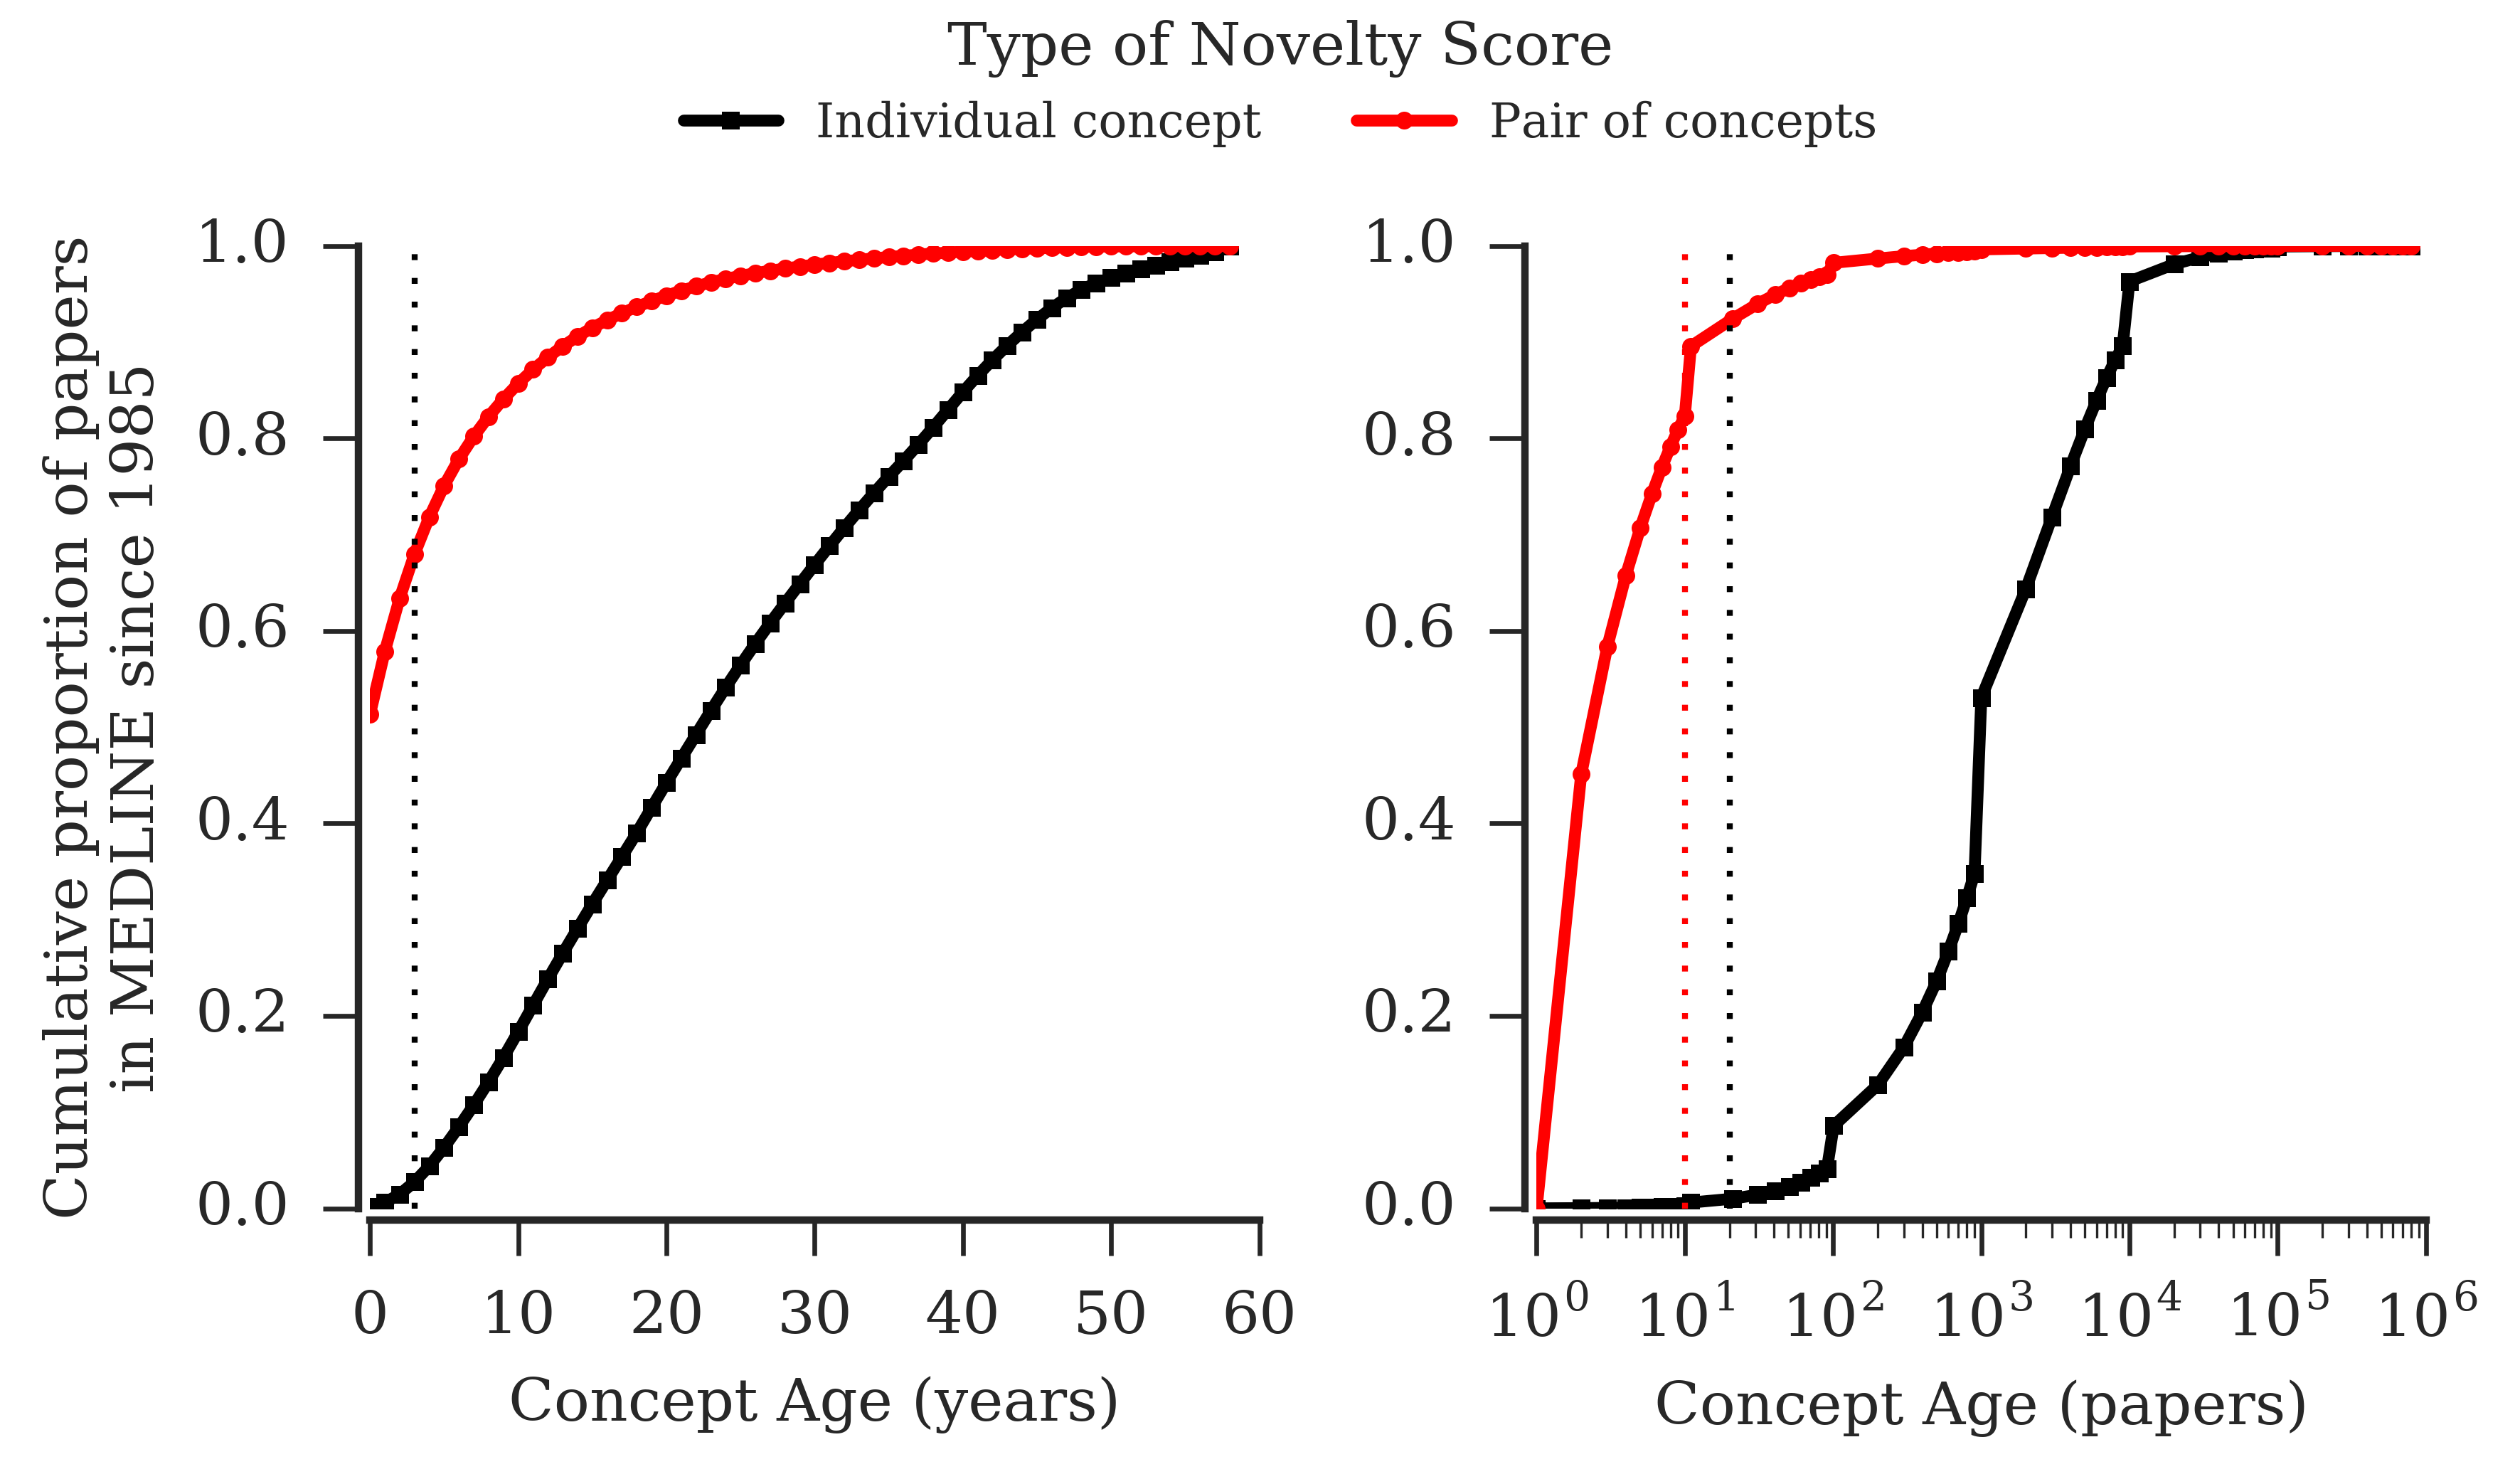

In [97]:
# Plot distribion data
plt.close("all")
plt.clf()
fig, ax = plt.subplots(1,2, figsize=(6,3.2))

score_types = ["TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"]
y_label = "Cumulative proportion of papers\nin MEDLINE since 1985"
x_labels = ["Years since first publication", "Papers since first publication"]
x_labels = ["Concept Age (years)", "Concept Age (papers)"]

labels = ["Individual concept (n = %.1fM)" % (sum(data[0][1]) * 1./1e6),
          "Pair of concepts (n = %.1fM)" % (sum(data[2][1]) * 1./1e6)]

labels = ["Individual concept", "Pair of concepts"]
colors = ["black", "red"]
markers = ["s", "o"]

for i, k in enumerate(score_types):
    print "Plotting %s" % k
    j = i % 2
    x, y = data[i]
    x = np.array(x[:-1])
    if "VolFirstP" in k:
        x = x + 1.0
    y = np.cumsum(y) * 1.0 / np.sum(y)
    ax[j].plot(x, y, marker=markers[i/2], color=colors[i/2], label=labels[i/2], lw=2)

ax[0].set_ylabel(y_label)
ax[0].set_xlabel(x_labels[0])
ax[0].axvline(x=3, linestyle=":", color="black")
ax[1].set_xscale("log")
ax[1].set_xlabel(x_labels[1])
ax[1].axvline(x=20, linestyle=":", color="black")
ax[1].axvline(x=10, linestyle=":", color="red")


sns.despine(offset=2, trim=True)

lgd = fig.legend(*ax[0].get_legend_handles_labels(),
    loc = 'upper center',bbox_to_anchor=(0.5, 1.1),
    title = "Type of Novelty Score",
    ncol=2, frameon=False, fancybox=False)
fig.tight_layout()
plt.savefig("%s/ScoreDistribution.pdf" % PLOT_DIR, bbox_inches='tight', bbox_extra_artists=[lgd])


In [7]:
cutoff = [3,20,3,10]
score_types = ["TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"]
for i, k in enumerate(score_types):
    df_t = pd.DataFrame({"x": data[i][0][:-1], "y": data[i][1]})
    prop = df_t[df_t.x <= cutoff[i]].y.sum() * 100./ df_t.y.sum()
    print "Percentage of papers with %s less than %s = %.4f%%" % (k,cutoff[i], prop)


Percentage of papers with TFirstP less than 3 = 2.7431%
Percentage of papers with VolFirstP less than 20 = 0.9982%
Percentage of papers with Pair_TFirstP less than 3 = 67.9664%
Percentage of papers with Pair_VolFirstP less than 10 = 89.5760%


In [8]:
# Growth data
score_types = ["acc_pos_vel_min", "acc_neg_vel_max"]
bins = [-0.1, 0] + np.logspace(-45,0,100).tolist() + [1.1]
data_acc_growth = df[(df["Year"] >= 1985) & (~df["acc_pos_vel_min"].isNull())].rdd.map(lambda x: min(x["acc_pos_vel_min"], 1)).histogram(bins)
bins = [-0.1, 0] + np.logspace(-10,0,100).tolist() + [1.1]
data_dec_growth = df[(df["Year"] >= 1985) & (df["acc_pos_vel_min"].isNull())].rdd.map(lambda x: min(x["acc_neg_vel_max"], 1)).histogram(bins)


Plotting acc_pos_vel_min
Plotting acc_neg_vel_max


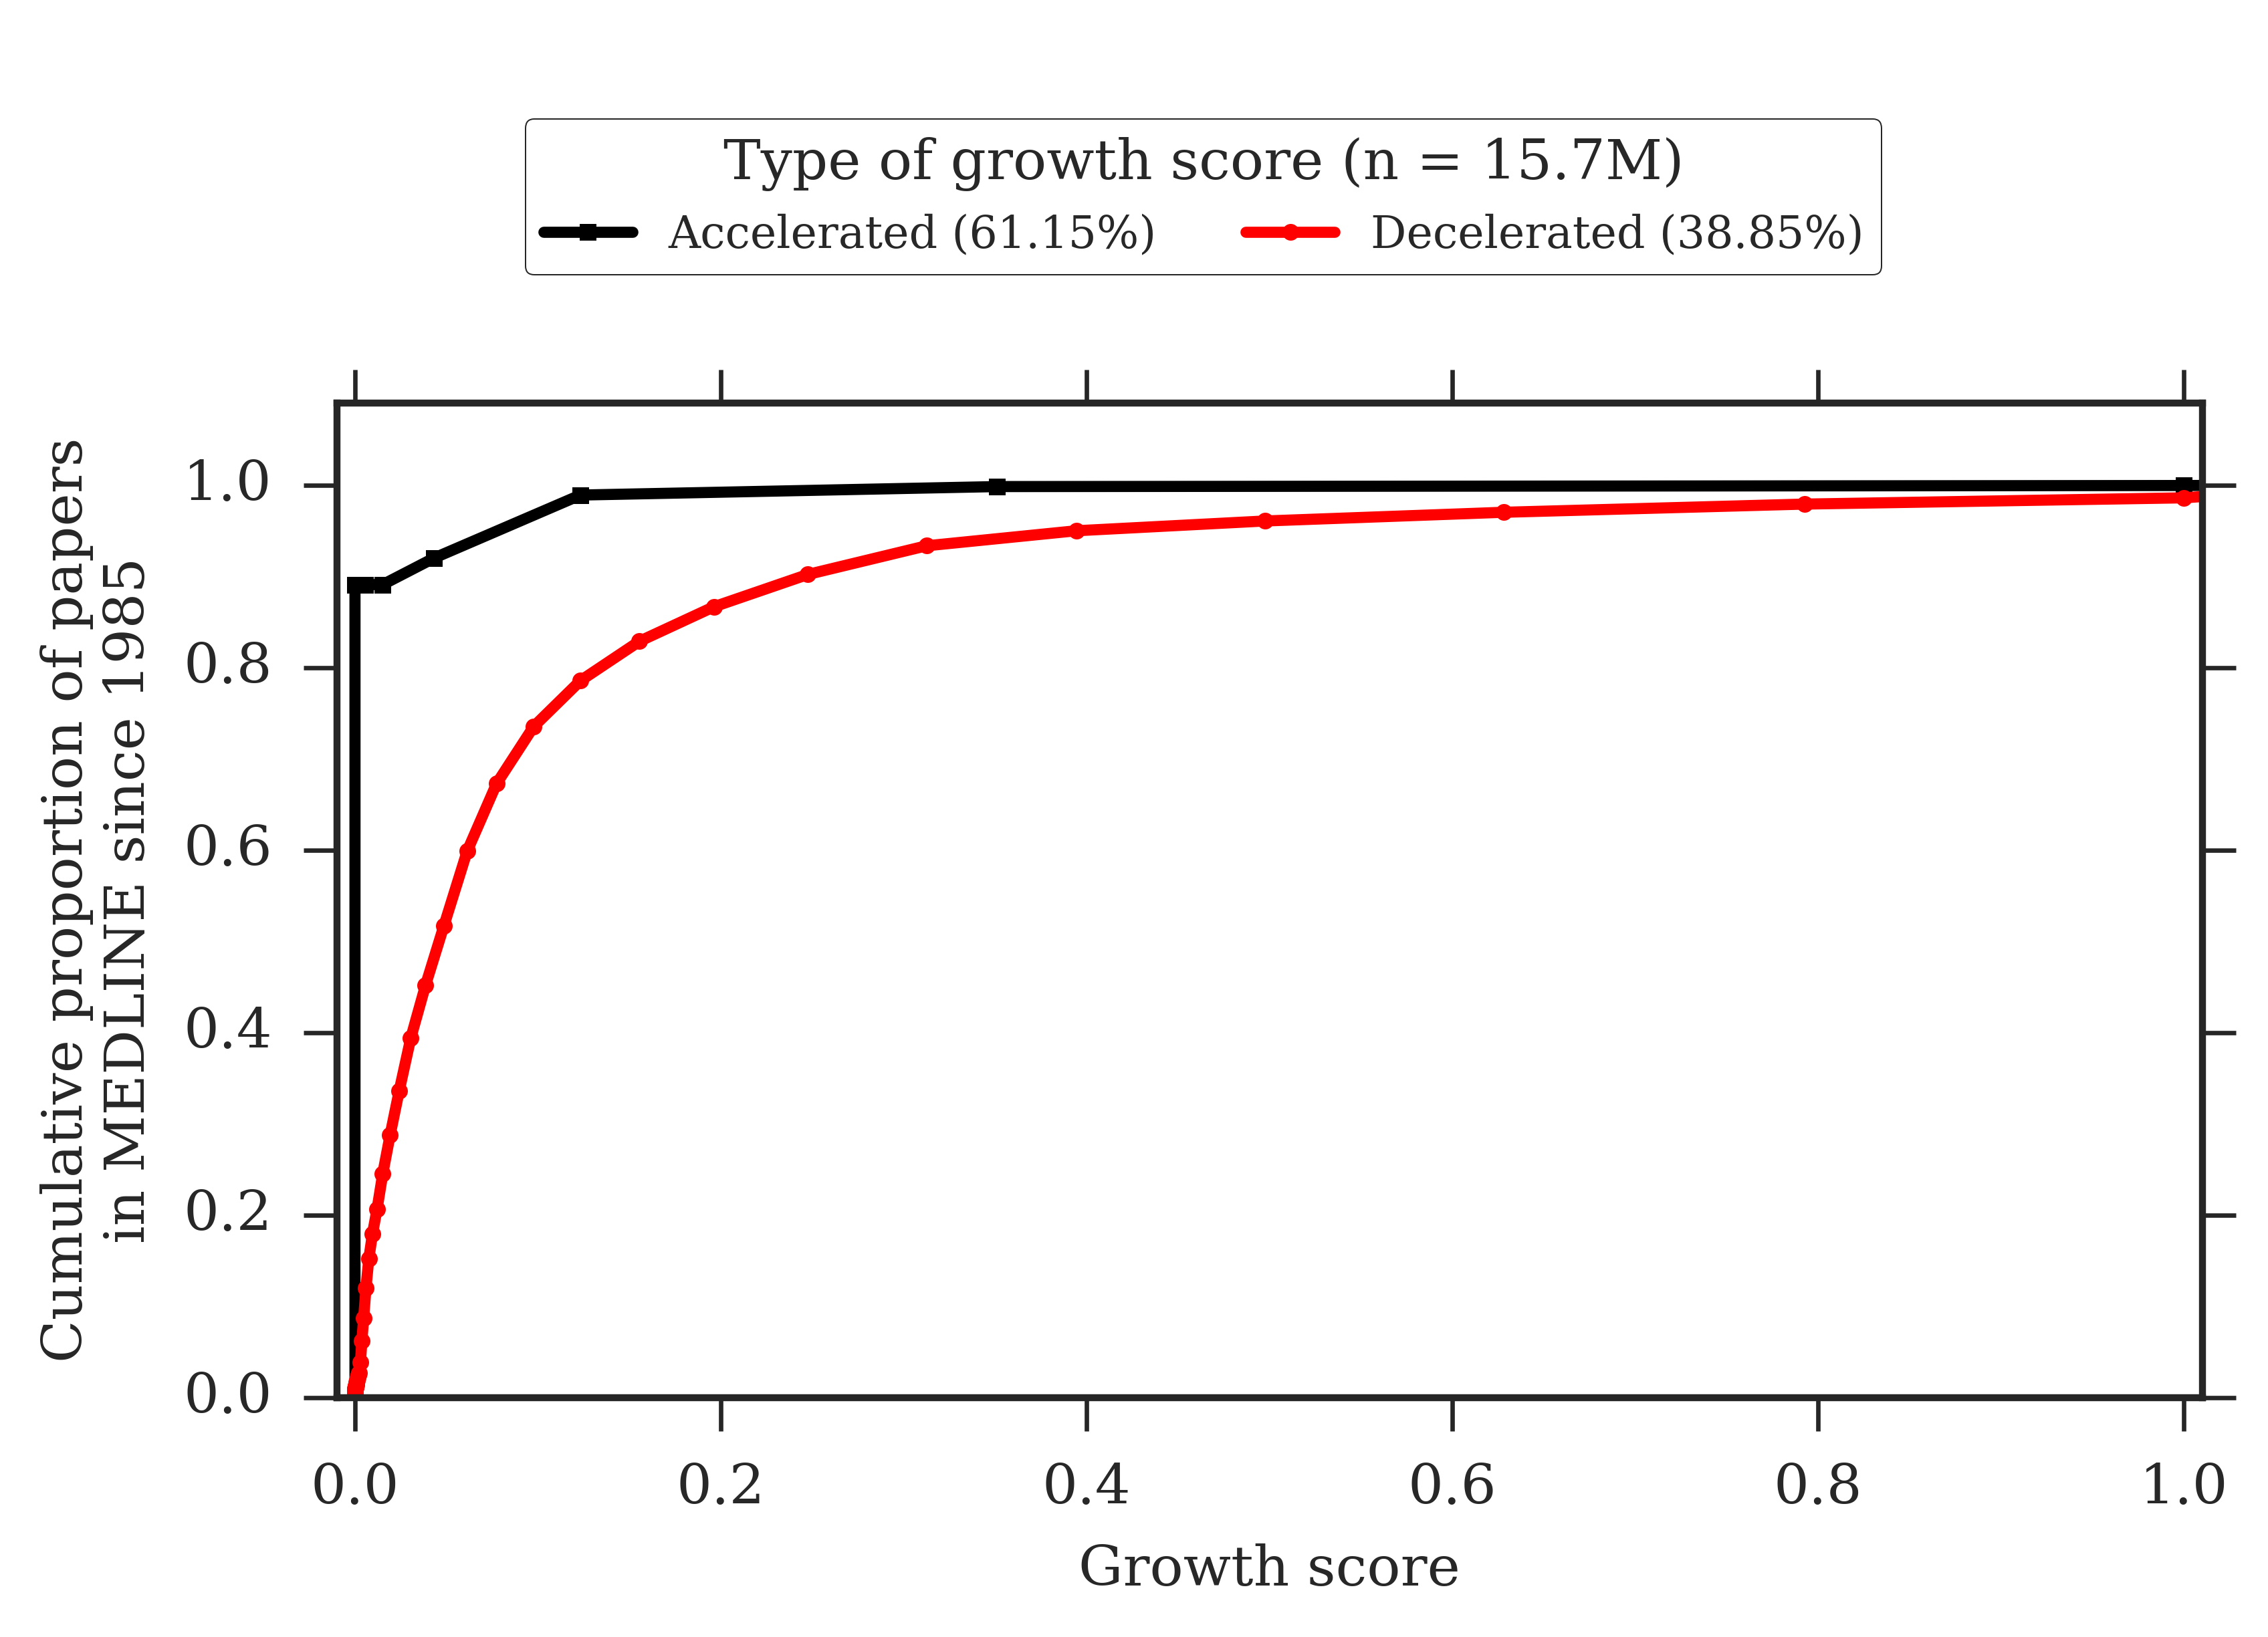

In [14]:
data_g = [data_acc_growth, data_dec_growth]

plt.close("all")
plt.clf()
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,3.2))
score_types = ["acc_pos_vel_min", "acc_neg_vel_max"]
y_label = "Cumulative proportion of papers\nin MEDLINE since 1985"
x_labels = "Growth score"
t = np.array([sum(data_acc_growth[1]),sum(data_dec_growth[1])])
t = t * 100./ t.sum()
labels = ["Accelerated (%.2f%%)" % t[0] , "Decelerated (%.2f%%)" % t[1]]
colors = ["black", "red"]
markers = ["s", "o"]

for i, k in enumerate(score_types):
    print "Plotting %s" % k
    x, y = data_g[i]
    x = np.array(x[1:])
    y = np.cumsum(y) * 1.0 / np.sum(y)
    ax.plot(x, y, marker=markers[i], color=colors[i], label=labels[i], lw=2)

ax.set_ylabel(y_label)
ax.set_xlabel(x_labels)
ax.set_ylim([0,1.09])
ax.set_xlim([-0.01,1.01])
#ax.set_xscale("log")

lgd = fig.legend(*ax.get_legend_handles_labels(),
    loc = 'upper center',bbox_to_anchor=(0.5, 1.2),
    title = "Type of growth score (n = %.1fM)" % (sum([sum(data_acc_growth[1]),sum(data_dec_growth[1])]) * (1./1e6)),
    ncol=2, frameon=True, fancybox=True)
plt.savefig("%s/GrowthScoreDistribution.pdf" % PLOT_DIR, bbox_inches='tight', bbox_extra_artists=[lgd])
##plt.savefig("%s/GrowthScoreDistribution.pdf" % PLOT_DIR, bbox_inches='tight')

In [10]:
data_acc_growth[1][0]* 100.0/ sum(data_acc_growth[1])

0.0

In [12]:
t = np.array([sum(data_acc_growth[1]),sum(data_dec_growth[1])])
t * 100./ t.sum()

array([ 61.14518209,  38.85481791])

In [23]:
df.head()

Row(PMID=23199754, Year=2012, AbsVal=18, TFirstP=9, VolFirstP=121.0, acc_pos_vel_min=0.240273, acc_pos_vel_max=0.240273, acc_neg_vel_max=0.12302, acc_neg_vel_min=2.68515e-08, Pair_AbsVal=1.0, Pair_TFirstP=0.0, Pair_VolFirstP=1.0, Mesh_counts=9, Exploded_Mesh_counts=27)

In [83]:
t = df[["PMID", "Year"]].groupby("Year").count().toPandas()

In [84]:
t = t.sort_values("Year")

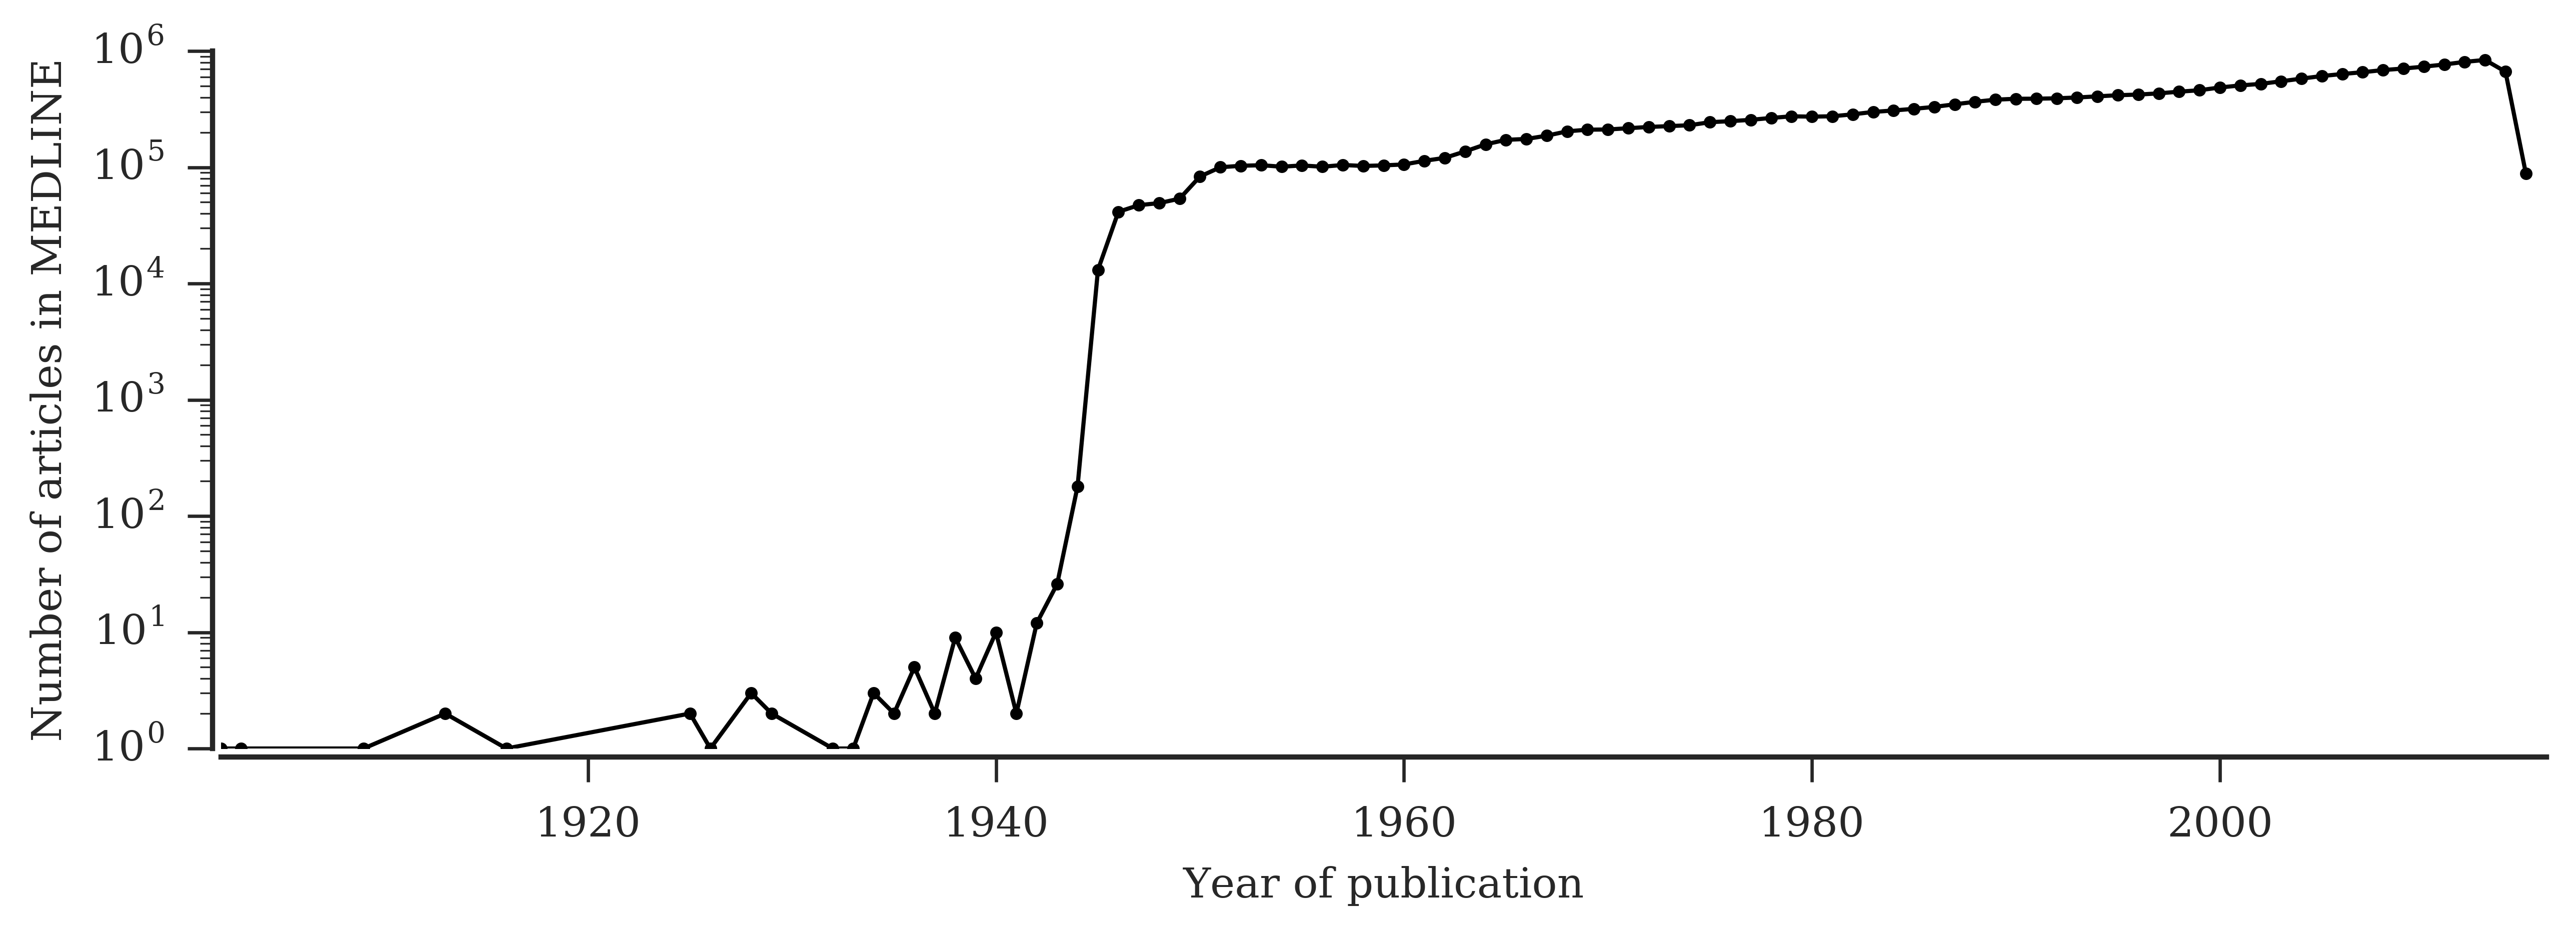

In [37]:
plt.close("all")
plt.clf()
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(t.Year, t["count"], "-ko")
ax.set_yscale("log")
ax.set_xlim([1902,2016])
ax.set_ylabel("Number of articles in MEDLINE")
ax.set_xlabel("Year of publication")
sns.despine(offset=2)

In [39]:
! head out/mesh_exploded_scores/part-00000

Maxillofacial Development	1945	1	0	1.0	0.0	1.22007403144e-125	0.0
Maxillofacial Development	1946	13	1	14.0	0.0	5.06940485805e-119	0.0
Maxillofacial Development	1947	8	2	22.0	0.0	2.10633657898e-112	0.0
Maxillofacial Development	1948	1	3	23.0	0.0	8.75182375089e-106	0.0
Maxillofacial Development	1963	1	18	24.0	6.2119931291e-08	1.66211258898e-06	2.53302994807e-05
Maxillofacial Development	1964	23	19	47.0	0.332665394697	5.67356593574	70.2753547917
Maxillofacial Development	1965	95	20	142.0	56.9015214407	0.000155806983869	-0.00237445970394
Maxillofacial Development	1966	86	21	228.0	57.8835290347	3.74988674575e-11	-5.71476081951e-10
Maxillofacial Development	1967	109	22	337.0	61.7635865062	9.02500306731e-18	-1.37539444314e-16
Maxillofacial Development	1968	136	23	473.0	67.3347646134	2.17208374245e-24	-1e-20


In [40]:
mesh_data = sc.textFile("out/mesh_exploded_scores/part-*").map(
    lambda x: x.split("\t")).map(
    lambda x: (x[0], int(x[1]))).reduceByKey(
    lambda x,y: min(x,y)).map(lambda x: (x[1], x[0])).countByKey()

In [42]:
t_m = pd.DataFrame(mesh_data.items(), columns=["Year", "count"])
t_m.head()

,Year,count
0,1902,39
1,1903,31
2,1909,7
3,1913,14
4,1916,21


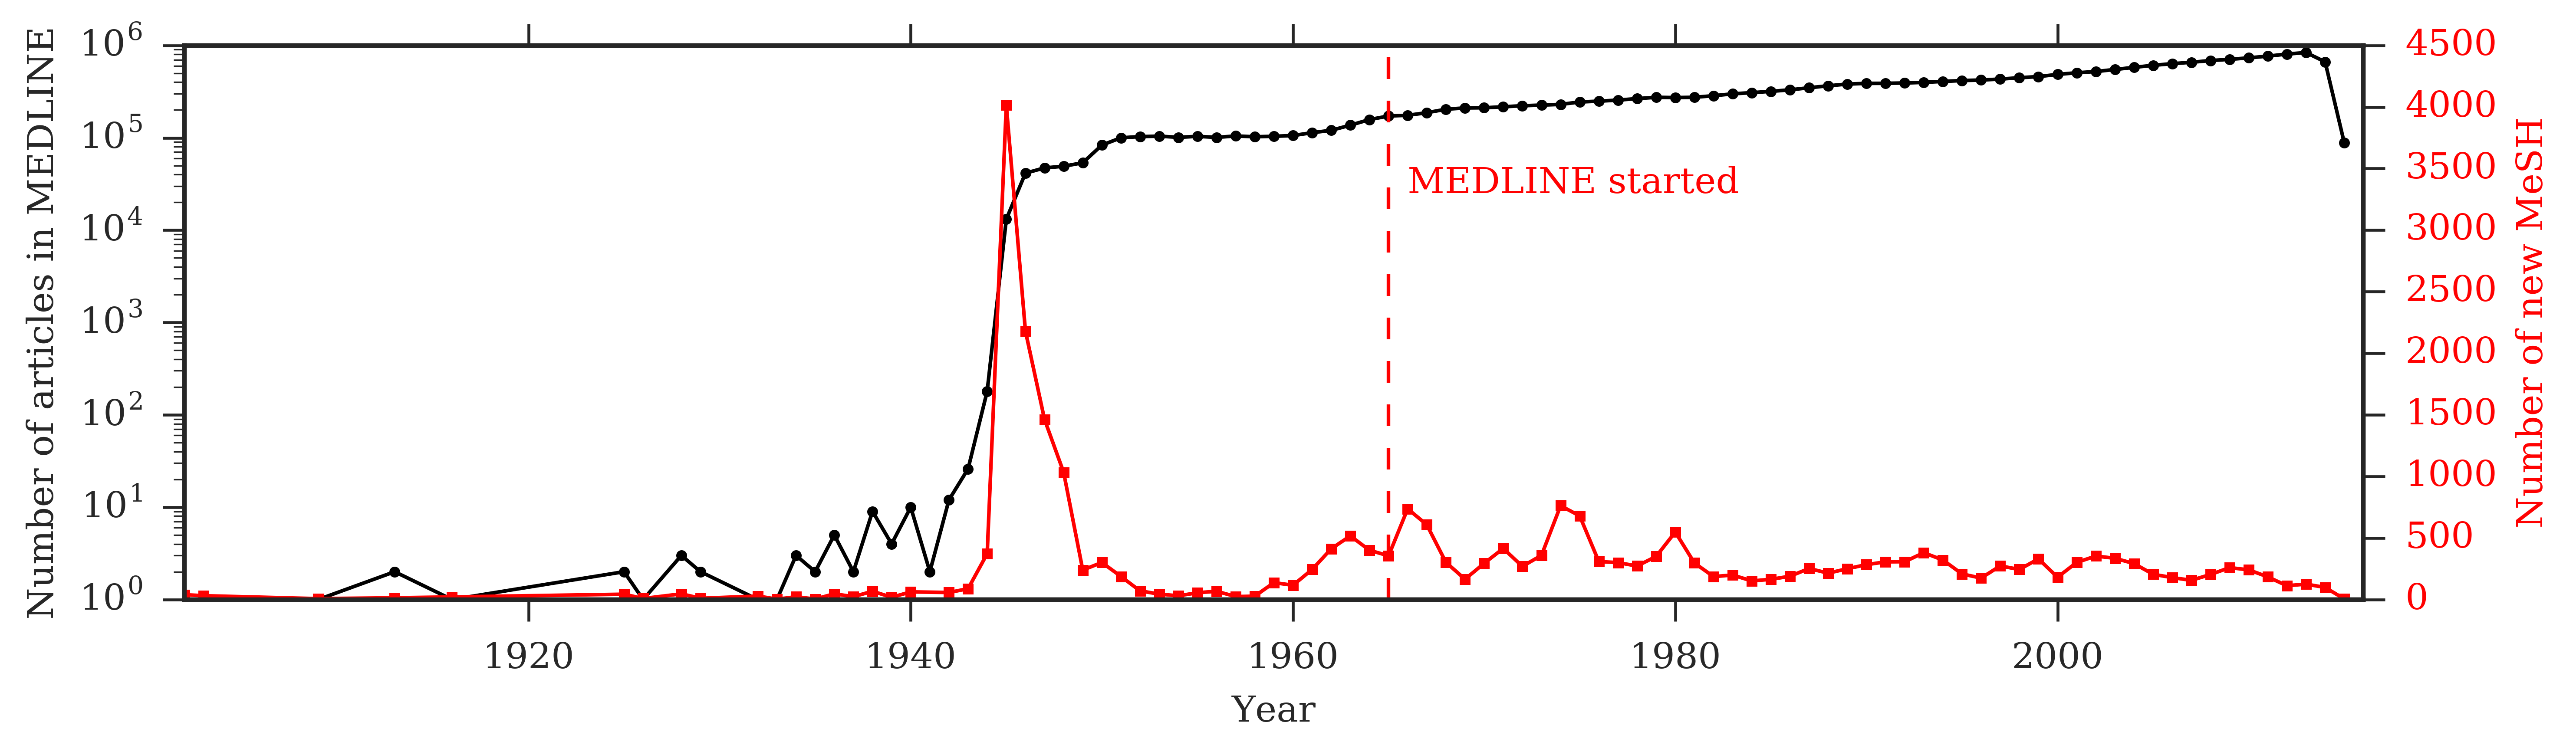

In [90]:
plt.close("all")
plt.clf()
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(t.Year, t["count"], "-ko")
ax.set_yscale("log")
ax.set_xlim([1902,2016])
ax.set_ylabel("Number of articles in MEDLINE")
ax.set_xlabel("Year")

ax_m = ax.twinx()
ax_m.plot(t_m.Year, t_m["count"], "-rs")
ax_m.set_xlim([1902,2016])
ax_m.set_ylabel("Number of new MeSH", color='r')
ax_m.axvline(x=1965, linestyle="--", color="r")
ax_m.text(1966, 3300, 'MEDLINE started', rotation=0, color="r")
for tl in ax_m.get_yticklabels():
    tl.set_color('r')
fig.tight_layout()
plt.savefig("plots/JCDL_WOSP/MedlineGrowth.pdf", bbox_inches="tight")


In [66]:
t1 = df[["Mesh_counts", "Year"]].groupby("Year").mean().toPandas()
t1 = t1[t1.columns[:2]]
t1.columns = ["Year", "Mean_MeSH"]
t1 = t1.set_index("Year")

t2 = df[["Mesh_counts", "Year"]].groupby("Year").agg({"Mesh_counts": "stddev"}).toPandas()
t2.columns = ["Year", "Std_MeSH"]
t2 = t2.set_index("Year")

In [67]:
t2.head()

,Std_MeSH
Year,
1959,0.989256
1990,3.920335
1903,NaN
1975,4.554442
1977,3.761122


In [68]:
t1["Std_MeSH"] = t2["Std_MeSH"]
t1.head()

,Mean_MeSH,Std_MeSH
Year,,
1959,1.841383,0.989256
1990,9.432538,3.920335
1903,16.000000,NaN
1975,9.213027,4.554442
1977,8.394893,3.761122


In [77]:
t1 = t1.sort_index()

In [80]:
t1.head()

,Mean_MeSH,Std_MeSH
Year,,
1902,17.0,NaN
1903,16.0,NaN
1909,7.0,NaN
1913,11.5,4.949747
1916,18.0,NaN


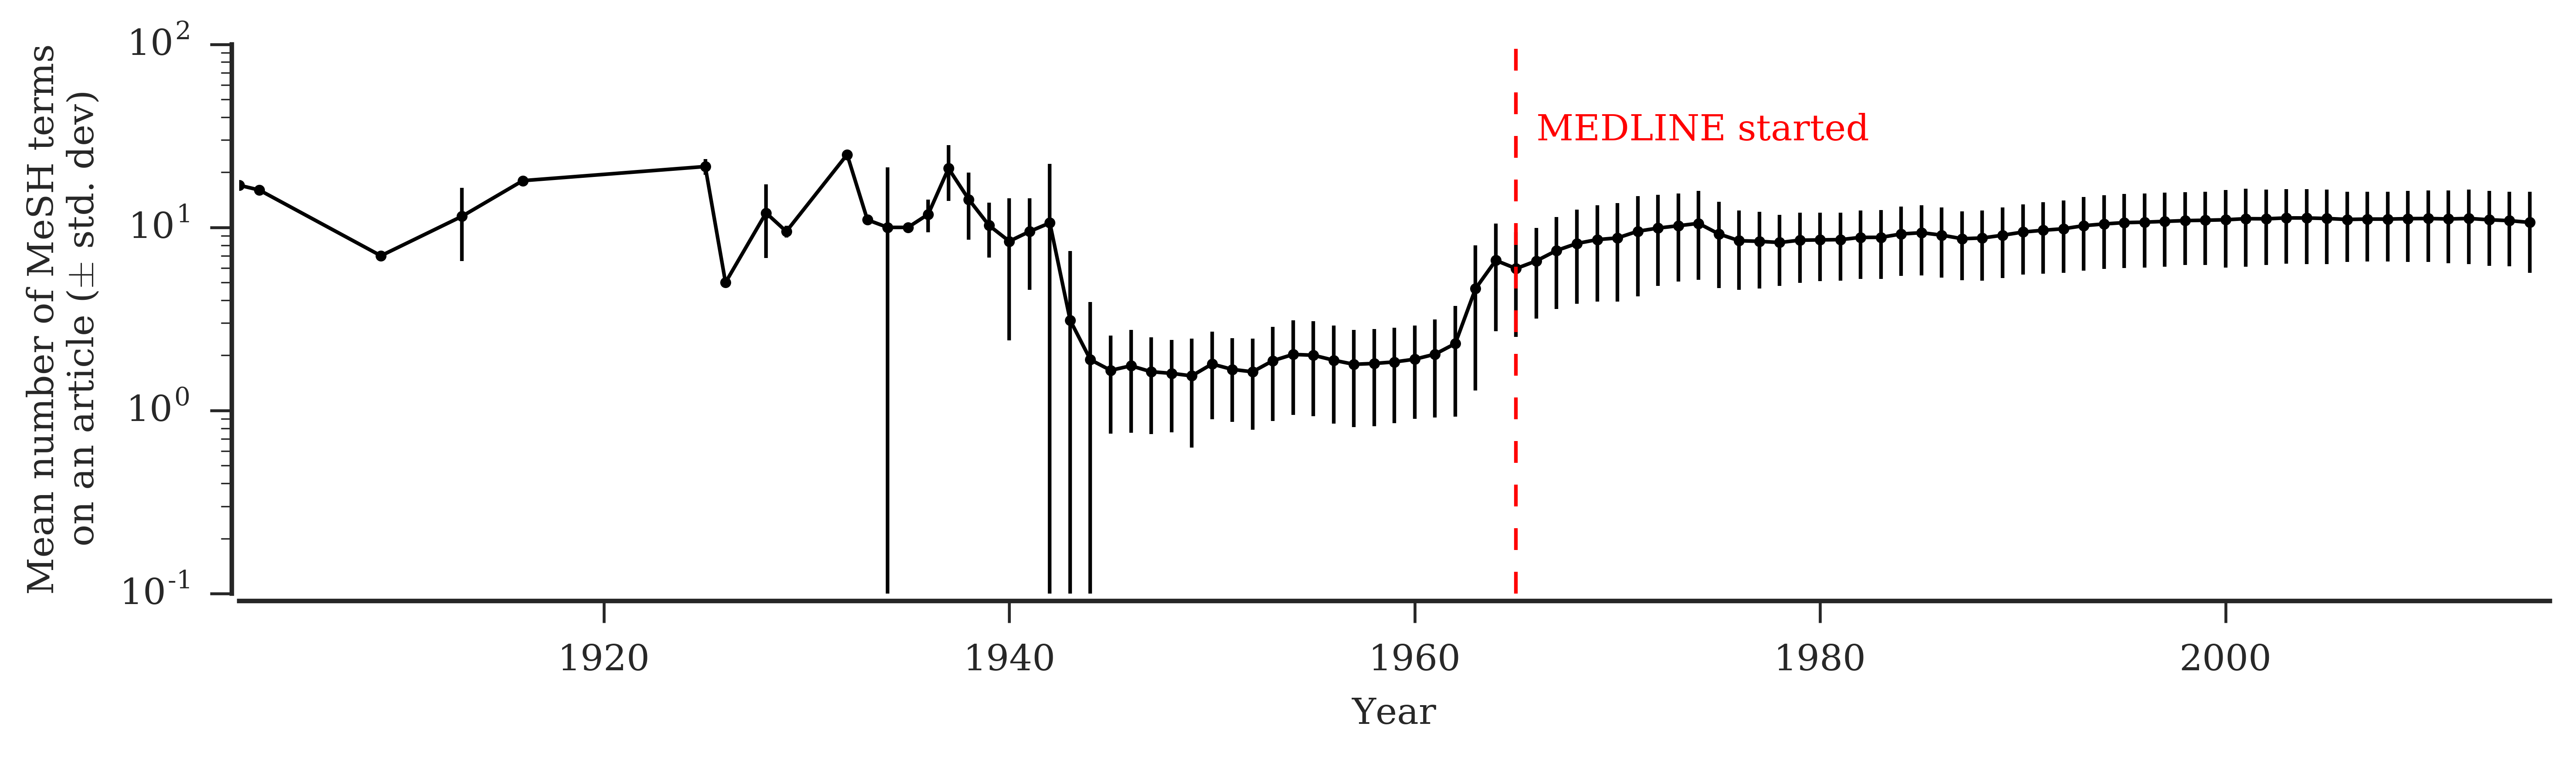

In [88]:
plt.close("all")
plt.clf()
fig, ax = plt.subplots(figsize=(10,3))
ax.errorbar(t1.index.values, t1.Mean_MeSH.values, yerr=t1.Std_MeSH.values, color="k", marker="o")
ax.set_yscale("log")
ax.set_xlim([1902,2016])
ax.set_ylabel("Mean number of MeSH terms\non an article ($\pm$ std. dev)")
ax.set_xlabel("Year")
ax.axvline(x=1965, linestyle="--", color="r")
ax.text(1966, 30, 'MEDLINE started', rotation=0, color="r")
sns.despine(offset=2)
fig.tight_layout()
plt.savefig("plots/JCDL_WOSP/MedlineMeanMeSH.pdf", bbox_inches="tight")


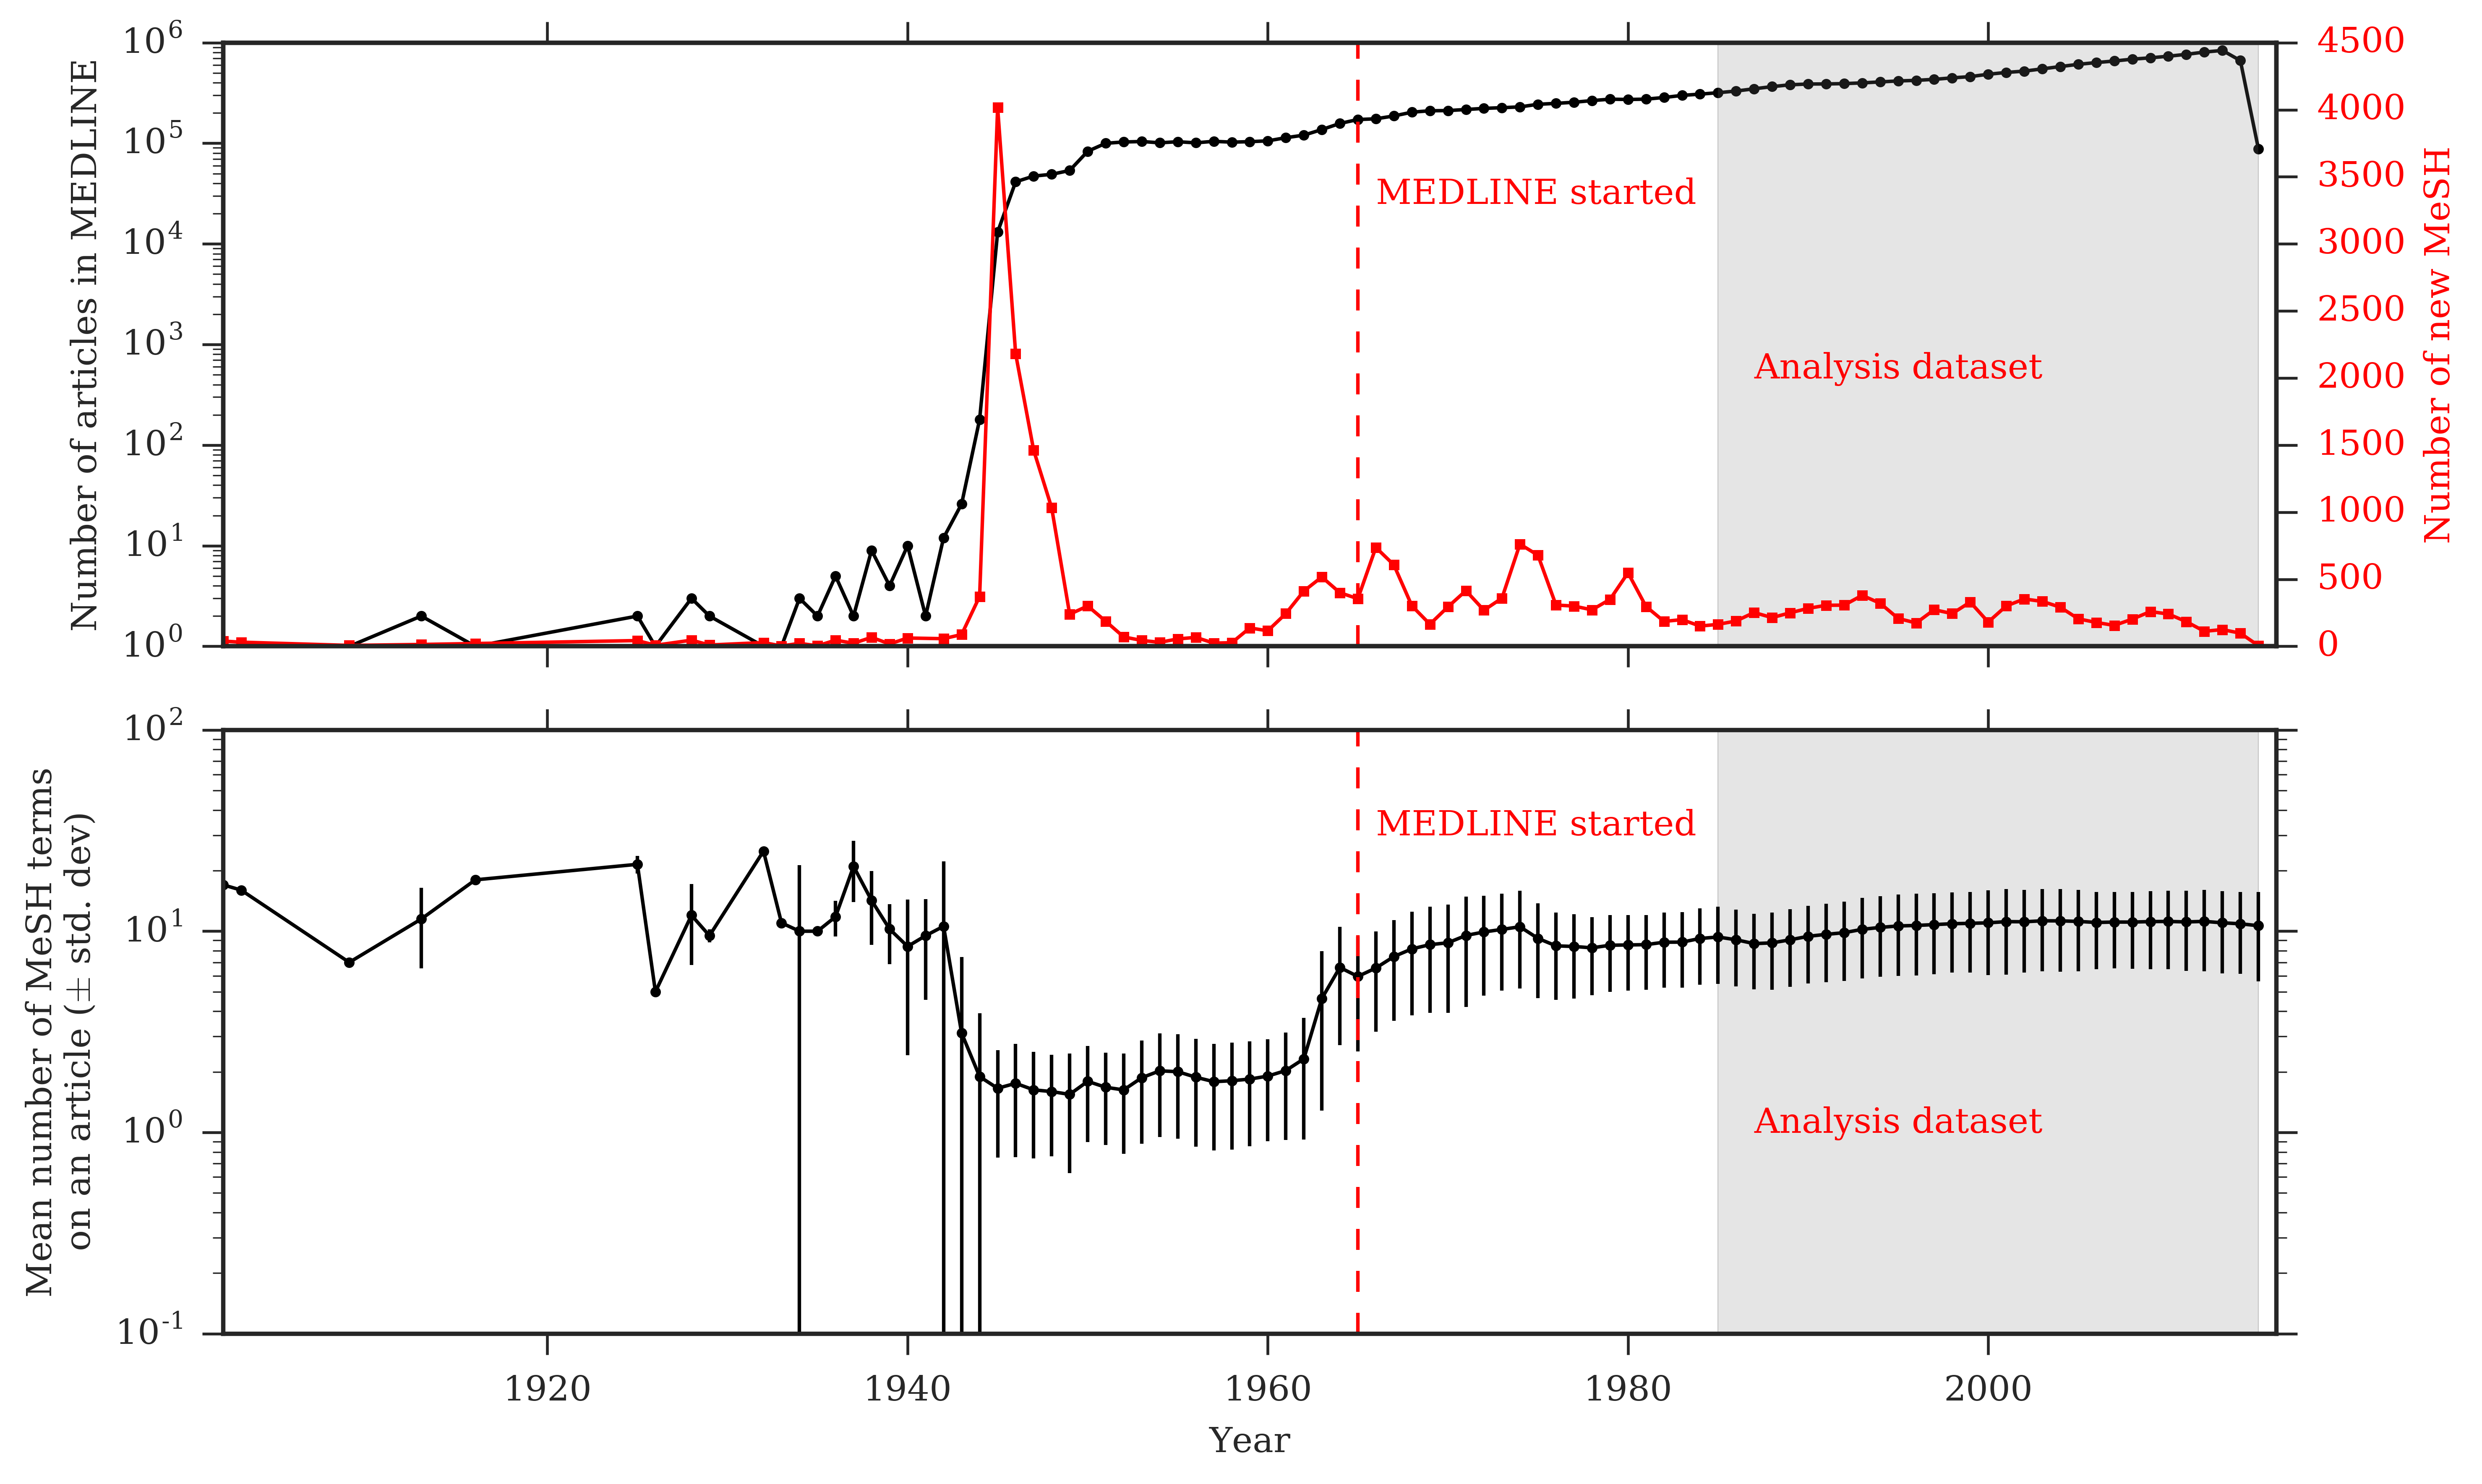

In [110]:
plt.close("all")
plt.clf()
fig, ax = plt.subplots(2,1,sharex=True,figsize=(10,6))
ax[0].plot(t.Year, t["count"], "-ko")
ax[0].set_yscale("log")
ax[0].set_xlim([1902,2016])
ax[0].set_ylabel("Number of articles in MEDLINE")
#ax[0].set_xlabel("Year")

ax_m = ax[0].twinx()
ax_m.plot(t_m.Year, t_m["count"], "-rs")
ax_m.set_xlim([1902,2016])
ax_m.set_ylabel("Number of new MeSH", color='r')
ax_m.axvline(x=1965, linestyle="--", color="r")
ax_m.text(1966, 3300, 'MEDLINE started', rotation=0, color="r")
ax_m.text(1987, 2000, 'Analysis dataset', rotation=0, color="r")
ax_m.axvspan(1985, 2015, facecolor='grey', alpha=0.2)
for tl in ax_m.get_yticklabels():
    tl.set_color('r')

ax[1].errorbar(t1.index.values, t1.Mean_MeSH.values, yerr=t1.Std_MeSH.values, color="k", marker="o")
ax[1].set_yscale("log")
ax[1].set_xlim([1902,2016])
ax[1].set_ylabel("Mean number of MeSH terms\non an article ($\pm$ std. dev)")
ax[1].set_xlabel("Year")
ax[1].axvline(x=1965, linestyle="--", color="r")
ax[1].text(1966, 30, 'MEDLINE started', rotation=0, color="r")
ax[1].text(1987, 1, 'Analysis dataset', rotation=0, color="r")
ax[1].axvspan(1985, 2015, facecolor='grey', alpha=0.2)

fig.tight_layout()
plt.savefig("plots/JCDL_WOSP/MedlineGrowth.pdf", bbox_inches="tight")